In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
!pip install tensorflow_addons

In [3]:
import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)
from google.colab import drive
import numpy as np
import os
import pandas as pd

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

2.4.1


In [4]:
# mount gdrive containing trained checkpoint objects
drive.mount('/content/drive', force_remount=True )

Mounted at /content/drive


##--Generate Training Data--##

In [5]:
def generate_graph_seq2seq_io_data(
        df, x_offsets, y_offsets, add_time_in_day=True, add_day_in_week=True, scaler=None
):
    """
    Generate samples from
    :param df:
    :param x_offsets:
    :param y_offsets:
    :param add_time_in_day:
    :param add_day_in_week:
    :param scaler:
    :return:
    # x: (epoch_size, input_length, num_nodes, input_dim)
    # y: (epoch_size, output_length, num_nodes, output_dim)
    """

    num_samples, num_nodes = df.shape
    #rows are time stamps, each colums is a sensor on the road? with an id
    # there are 12 features for each sensor?
    print("num_nodes: ", num_nodes, "\n\n")
    print("num features features: ", df.columns, "\n\n") #traffic speeds at each node and time of week currently, he doesnt need care for time of day
    print("VALUES:", df.values.shape)
    data = np.expand_dims(df.values, axis=-1)
    data_list = [data]
    if add_time_in_day:
        time_ind = (df.index.values - df.index.values.astype("datetime64[D]")) / np.timedelta64(1, "D")
        time_in_day = np.tile(time_ind, [1, num_nodes, 1]).transpose((2, 1, 0))
        data_list.append(time_in_day)
    if add_day_in_week:
        day_in_week = np.zeros(shape=(num_samples, num_nodes, 1))
        #print("da_in_week shape", day_in_week.shape)
        #print("df.index.dayofweek", df.index.dayofweek)
        for dow in range(207):
          day_in_week[np.arange(num_samples), dow, 0] = df.index.dayofweek/7
        data_list.append(day_in_week)

    print("list length:", len(data_list))
    data = np.concatenate(data_list, axis=-1)
    #print("data size: ", data[:,:,0].shape, data[10000,:,0])
    # epoch_len = num_samples + min(x_offsets) - max(y_offsets)
    x, y = [], []
    # t is the index of the last observation.
    min_t = abs(min(x_offsets))
    max_t = abs(num_samples - abs(max(y_offsets)))  # Exclusive
    print("min_t:", min_t, "max_t", max_t)
    for t in range(min_t, max_t):
        x_t = data[t + x_offsets, ...]
        #print(x_t.shape, "\n") = (12,207,2) the 12 features are previous traffic speeds at each node!!
        y_t = data[t + y_offsets, ...]
        x.append(x_t)
        y.append(y_t)
    x = np.stack(x, axis=0)
    y = np.stack(y, axis=0)
    print(x.shape, y.shape)
    return x, y


def generate_train_val_test(traffic_df_filename, output_dir):
    df = pd.read_hdf(traffic_df_filename)
    # 0 is the latest observed sample.
    x_offsets = np.sort(
        # np.concatenate(([-week_size + 1, -day_size + 1], np.arange(-11, 1, 1)))
        np.concatenate((np.arange(-11, 1, 1),))
    )
    print("x_offsets: ", x_offsets, "\n\n")
    # Predict the next one hour
    y_offsets = np.sort(np.arange(1, 13, 1))
    # x: (num_samples, input_length, num_nodes, input_dim)
    # y: (num_samples, output_length, num_nodes, output_dim)
    x, y = generate_graph_seq2seq_io_data(
        df,
        x_offsets=x_offsets,
        y_offsets=y_offsets,
        add_time_in_day=True,
        add_day_in_week=True,
    )

    print("HEYYY")
    #print("x: ", x[0, :, :, :])
    print("x shape: ", x.shape, ", y shape: ", y.shape)
    # Write the data into npz file.
    # num_test = 6831, using the last 6831 examples as testing.
    # for the rest: 7/8 is used for training, and 1/8 is used for validation.
    num_samples = x.shape[0]
    num_test = round(num_samples * 0.2)
    num_train = round(num_samples * 0.7)
    num_val = num_samples - num_test - num_train

    # train
    x_train, y_train = x[:num_train], y[:num_train]
    # val
    x_val, y_val = (
        x[num_train: num_train + num_val],
        y[num_train: num_train + num_val],
    )
    # test
    x_test, y_test = x[-num_test:], y[-num_test:]

    print("train ex", x_train[0,0,1:12,:])
    print("train ex", y_train[5000,0,1:12,:])
    for cat in ["train", "val", "test"]:
        _x, _y = locals()["x_" + cat], locals()["y_" + cat]
        print(cat, "x: ", _x.shape, "y:", _y.shape)
        np.savez_compressed(
            os.path.join(output_dir, "%s.npz" % cat),
            x=_x,
            y=_y,
            x_offsets=x_offsets.reshape(list(x_offsets.shape) + [1]),
            y_offsets=y_offsets.reshape(list(y_offsets.shape) + [1]),
        )


print("Generating training data")
generate_train_val_test("drive/MyDrive/datatf2/data/metr-la.h5", "drive/MyDrive/datatf2/data/METR-LA")

Generating training data
x_offsets:  [-11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0] 


num_nodes:  207 


num features features:  Index(['773869', '767541', '767542', '717447', '717446', '717445', '773062',
       '767620', '737529', '717816',
       ...
       '772167', '769372', '774204', '769806', '717590', '717592', '717595',
       '772168', '718141', '769373'],
      dtype='object', length=207) 


VALUES: (34272, 207)
list length: 3
min_t: 11 max_t 34260
(34249, 12, 207, 3) (34249, 12, 207, 3)
HEYYY
x shape:  (34249, 12, 207, 3) , y shape:  (34249, 12, 207, 3)
train ex [[67.625       0.          0.42857143]
 [67.125       0.          0.42857143]
 [61.5         0.          0.42857143]
 [66.875       0.          0.42857143]
 [68.75        0.          0.42857143]
 [65.125       0.          0.42857143]
 [67.125       0.          0.42857143]
 [59.625       0.          0.42857143]
 [62.75        0.          0.42857143]
 [55.5         0.          0.42857143]
 [66.5         0.        

##--Adjacency Matrix--##

In [6]:
import numpy as np
import pandas as pd
import pickle


def get_adjacency_matrix(distance_df, sensor_ids, normalized_k=0.1):
    """

    :param distance_df: data frame with three columns: [from, to, distance].
    :param sensor_ids: list of sensor ids.
    :param normalized_k: entries that become lower than normalized_k after normalization are set to zero for sparsity.
    :return:
    """
    num_sensors = len(sensor_ids)
    dist_mx = np.zeros((num_sensors, num_sensors), dtype=np.float32)
    dist_mx[:] = np.inf
    # Builds sensor id to index map.
    sensor_id_to_ind = {}
    for i, sensor_id in enumerate(sensor_ids):
        sensor_id_to_ind[sensor_id] = i

    # Fills cells in the matrix with distances.
    for row in distance_df.values:
        if row[0] not in sensor_id_to_ind or row[1] not in sensor_id_to_ind:
            continue
        dist_mx[sensor_id_to_ind[row[0]], sensor_id_to_ind[row[1]]] = row[2]

    # Calculates the standard deviation as theta.
    distances = dist_mx[~np.isinf(dist_mx)].flatten()
    print("isinf: ", ~np.isinf(dist_mx), "\n", np.isinf(dist_mx).shape, "\n") #the ~ does the not of the function, so returning all values where its not infinite
    print("distances: ", distances, "\n", distances.shape, "\n")
    std = distances.std()
    adj_mx = np.exp(-np.square(dist_mx / std))
    # Make the adjacent matrix symmetric by taking the max.
    # adj_mx = np.maximum.reduce([adj_mx, adj_mx.T])

    # Sets entries that lower than a threshold, i.e., k, to zero for sparsity.
    adj_mx[adj_mx < normalized_k] = 0
    print("adj_max: ", adj_mx, "\n\n", adj_mx.shape, "\n")
    return sensor_ids, sensor_id_to_ind, adj_mx


with open("drive/MyDrive/datatf2/data/sensor_graph/graph_sensor_ids.txt") as f:
    sensor_ids = f.read().strip().split(',')
distance_df = pd.read_csv("drive/MyDrive/data/data/sensor_graph/distances_la_2012.csv", dtype={'from': 'str', 'to': 'str'})
normalized_k = 0.1
_, sensor_id_to_ind, adj_mx = get_adjacency_matrix(distance_df, sensor_ids, normalized_k)
# Save to pickle file.
with open("drive/MyDrive/datatf2/data/sensor_graph/adj_mx.pkl", 'wb') as f:
    pickle.dump([sensor_ids, sensor_id_to_ind, adj_mx], f, protocol=2)

isinf:  [[ True False False ... False  True  True]
 [False  True  True ... False False False]
 [False  True  True ... False False  True]
 ...
 [False False False ...  True False False]
 [ True False False ... False  True False]
 [ True  True False ... False  True  True]] 
 (207, 207) 

distances:  [    0.   8251.2 10020.6 ...  2757.2  9018.7     0. ] 
 (11753,) 

adj_max:  [[1.        0.        0.        ... 0.        0.        0.       ]
 [0.        1.        0.3909554 ... 0.        0.        0.       ]
 [0.        0.7174379 1.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 1.        0.        0.       ]
 [0.        0.        0.        ... 0.        1.        0.       ]
 [0.        0.        0.        ... 0.        0.        1.       ]] 

 (207, 207) 



##--Utils--##

In [7]:
import logging
import numpy as np
import os
import pickle
import scipy.sparse as sp
import sys
import tensorflow as tf

from scipy.sparse import linalg


class DataLoader(object):
    def __init__(self, xs, ys, batch_size, pad_with_last_sample=True, shuffle=False):
        """

        :param xs:
        :param ys:
        :param batch_size:
        :param pad_with_last_sample: pad with the last sample to make number of samples divisible to batch_size.
        """
        self.batch_size = batch_size
        self.current_ind = 0
        if pad_with_last_sample:
            num_padding = (batch_size - (len(xs) % batch_size)) % batch_size
            x_padding = np.repeat(xs[-1:], num_padding, axis=0)
            y_padding = np.repeat(ys[-1:], num_padding, axis=0)
            xs = np.concatenate([xs, x_padding], axis=0)
            ys = np.concatenate([ys, y_padding], axis=0)
        self.size = len(xs)
        self.num_batch = int(self.size // self.batch_size)
        if shuffle:
            permutation = np.random.permutation(self.size)
            xs, ys = xs[permutation], ys[permutation]
        self.xs = xs
        self.ys = ys

    def get_iterator(self):
        self.current_ind = 0

        def _wrapper():
            while self.current_ind < self.num_batch:
                start_ind = self.batch_size * self.current_ind
                end_ind = min(self.size, self.batch_size * (self.current_ind + 1))
                x_i = self.xs[start_ind: end_ind, ...]
                y_i = self.ys[start_ind: end_ind, ...]
                yield (x_i, y_i)
                self.current_ind += 1

        return _wrapper()


class StandardScaler:
    """
    Standard the input
    """

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def transform(self, data):
        return (data - self.mean) / self.std

    def inverse_transform(self, data):
        return (data * self.std) + self.mean

def calculate_normalized_laplacian(adj):
    """
    # L = D^-1/2 (D-A) D^-1/2 = I - D^-1/2 A D^-1/2
    # D = diag(A 1)
    :param adj:
    :return:
    """
    adj = sp.coo_matrix(adj)
    d = np.array(adj.sum(1))
    d_inv_sqrt = np.power(d, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    normalized_laplacian = sp.eye(adj.shape[0]) - adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()
    return normalized_laplacian


def calculate_random_walk_matrix(adj_mx):
    adj_mx = sp.coo_matrix(adj_mx)
    d = np.array(adj_mx.sum(1))
    d_inv = np.power(d, -1).flatten()
    d_inv[np.isinf(d_inv)] = 0.
    d_mat_inv = sp.diags(d_inv)
    random_walk_mx = d_mat_inv.dot(adj_mx).tocoo()
    return random_walk_mx


def calculate_reverse_random_walk_matrix(adj_mx):
    return calculate_random_walk_matrix(np.transpose(adj_mx))


def calculate_scaled_laplacian(adj_mx, lambda_max=2, undirected=True):
    if undirected:
        adj_mx = np.maximum.reduce([adj_mx, adj_mx.T])
    L = calculate_normalized_laplacian(adj_mx)
    if lambda_max is None:
        lambda_max, _ = linalg.eigsh(L, 1, which='LM')
        lambda_max = lambda_max[0]
    L = sp.csr_matrix(L)
    M, _ = L.shape
    I = sp.identity(M, format='csr', dtype=L.dtype)
    L = (2 / lambda_max * L) - I
    return L.astype(np.float32)

def load_dataset(dataset_dir, batch_size, test_batch_size=None, **kwargs):
    data = {}
    for category in ['train', 'val', 'test']:
        cat_data = np.load(os.path.join(dataset_dir, category + '.npz'))
        data['x_' + category] = cat_data['x']
        data['y_' + category] = cat_data['y']
    scaler = StandardScaler(mean=data['x_train'][..., 0].mean(), std=data['x_train'][..., 0].std())
    # Data format
    for category in ['train', 'val', 'test']:
        data['x_' + category][..., 0] = scaler.transform(data['x_' + category][..., 0])
        data['y_' + category][..., 0] = scaler.transform(data['y_' + category][..., 0])
    data['train_loader'] = DataLoader(data['x_train'], data['y_train'], batch_size, shuffle=True)
    data['val_loader'] = DataLoader(data['x_val'], data['y_val'], test_batch_size, shuffle=False)
    data['test_loader'] = DataLoader(data['x_test'], data['y_test'], test_batch_size, shuffle=False)
    data['scaler'] = scaler

    return data


def load_graph_data(pkl_filename):
    sensor_ids, sensor_id_to_ind, adj_mx = load_pickle(pkl_filename)
    return sensor_ids, sensor_id_to_ind, adj_mx


def load_pickle(pickle_file):
    try:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f)
    except UnicodeDecodeError as e:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f, encoding='latin1')
    except Exception as e:
        print('Unable to load data ', pickle_file, ':', e)
        raise
    return pickle_data

##--Metrics--##

In [8]:
import numpy as np
import tensorflow as tf

def masked_mae_tf(preds, labels, null_val=np.nan):
    """
    Accuracy with masking.
    :param preds:
    :param labels:
    :param null_val:
    :return:
    """
    if np.isnan(null_val):
        mask = ~tf.math.is_nan(labels)
    else:
        mask = tf.not_equal(labels, null_val)
    mask = tf.cast(mask, tf.float32)
    mask /= tf.reduce_mean(mask)
    mask = tf.where(tf.math.is_nan(mask), tf.zeros_like(mask), mask)
    #print("PREDS", preds.shape, "LABELS", labels.shape)
    loss = tf.abs(tf.math.subtract(preds, labels))
    #print("LOSS", loss.shape, loss)
    loss = loss * mask
    loss = tf.where(tf.math.is_nan(loss), tf.zeros_like(loss), loss)
    loss = tf.reduce_mean(loss)
    #print("LOSS FINAL", loss)
    return loss


def masked_mae_np(preds, labels, null_val=np.nan):
    with np.errstate(divide='ignore', invalid='ignore'):
        if np.isnan(null_val):
            mask = ~np.isnan(labels)
        else:
            mask = np.not_equal(labels, null_val)
        mask = mask.astype('float32')
        mask /= np.mean(mask)
        mae = np.abs(np.subtract(preds, labels)).astype('float32')
        mae = np.nan_to_num(mae * mask)
        return np.mean(mae)

def masked_mae_loss(scaler, null_val):
    def loss(preds, labels):
        if scaler:
            preds = scaler.inverse_transform(preds)
            labels = scaler.inverse_transform(labels)
        mae = masked_mae_tf(preds=preds, labels=labels, null_val=null_val)
        return mae

    return loss

##--Model--##

In [9]:
class DCGRUCell(tf.keras.layers.AbstractRNNCell):
    """Graph Convolution Gated Recurrent Unit cell.
    """

    def call(self, inputs, **kwargs):
        pass

    def compute_output_shape(self, input_shape):
        pass

    def __init__(self, num_units, adj_mx, max_diffusion_step, num_nodes, num_proj=None,
                 activation=tf.nn.tanh, reuse=None, filter_type="laplacian", use_gc_for_ru=True):
        """

        :param num_units:
        :param adj_mx:
        :param max_diffusion_step:
        :param num_nodes:
        :param input_size:
        :param num_proj:
        :param activation:
        :param reuse:
        :param filter_type: "laplacian", "random_walk", "dual_random_walk".
        :param use_gc_for_ru: whether to use Graph convolution to calculate the reset and update gates.
        """
        super(DCGRUCell, self).__init__()#_reuse=reuse)
        self._activation = activation
        self._num_nodes = num_nodes
        self._num_proj = num_proj
        self._num_units = num_units
        self._max_diffusion_step = max_diffusion_step
        self._supports = []
        self._use_gc_for_ru = use_gc_for_ru
        supports = []
        if filter_type == "laplacian":
          #IN UTILS
            supports.append(calculate_scaled_laplacian(adj_mx, lambda_max=None))
        elif filter_type == "random_walk":
            supports.append(calculate_random_walk_matrix(adj_mx).T)
        elif filter_type == "dual_random_walk":
            supports.append(calculate_random_walk_matrix(adj_mx).T)
            supports.append(calculate_random_walk_matrix(adj_mx.T).T)
        else:
            supports.append(calculate_scaled_laplacian(adj_mx))
        for support in supports:
            self._supports.append(self._build_sparse_matrix(support))

    @staticmethod
    def _build_sparse_matrix(L):
        L = L.tocoo()
        indices = np.column_stack((L.row, L.col))
        L = tf.SparseTensor(indices, L.data, L.shape)
        return tf.sparse.reorder(L)

    #added by me
    def zero_state(self, batch_size, dtype):
      return tf.zeros([batch_size, self._num_nodes*self._num_units])

    @property
    def state_size(self):
        return self._num_nodes * self._num_units

    @property
    def output_size(self):
        output_size = self._num_nodes * self._num_units
        if self._num_proj is not None:
            output_size = self._num_nodes * self._num_proj
        return output_size

    def __call__(self, inputs, state, scope=None, training = True):
        """Gated recurrent unit (GRU) with Graph Convolution.
        :param inputs: (B, num_nodes * input_dim)

        :return
        - Output: A `2-D` tensor with shape `[batch_size x self.output_size]`.
        - New state: Either a single `2-D` tensor, or a tuple of tensors matching
            the arity and shapes of `state`
        """
        #print("INPUTS IS TEST:", inputs.shape)
        #print("VARIABEL SCOPE?", scope.reuse)
        with tf.compat.v1.variable_scope(scope or "dcgru_cell", reuse=tf.compat.v1.AUTO_REUSE):
            with tf.compat.v1.variable_scope("gates"):  # Reset gate and update gate.
                #print("gate")
                output_size = 2 * self._num_units
                # We start with bias of 1.0 to not reset and not update.
                if self._use_gc_for_ru:
                    fn = self._gconv
                else:
                    fn = self._fc
                print("value shape")
                value = tf.nn.sigmoid(fn(inputs, state, output_size, bias_start=1.0))
                value = tf.reshape(value, (-1, self._num_nodes, output_size))
                #print("value shape", value.shape)
                r, u = tf.split(value=value, num_or_size_splits=2, axis=-1)
                r = tf.reshape(r, (-1, self._num_nodes * self._num_units))
                u = tf.reshape(u, (-1, self._num_nodes * self._num_units))
            with tf.compat.v1.variable_scope("candidate"):
                c = self._gconv(inputs, r * state, self._num_units)
                if self._activation is not None:
                    c = self._activation(c)
            output = new_state = u * state[0] + (1 - u) * c
            if self._num_proj is not None:
                with tf.compat.v1.variable_scope("projection"):
                    #print("projection num units", self._num_units, "num proj", self._num_proj)
                    #print(type(tf.random.uniform((self._num_units, self._num_proj))))
                    #w = tf.Variable(name='w', initial_value=tf.random.uniform((self._num_units, self._num_proj)), shape=(self._num_units, self._num_proj))
                    w = tf.compat.v1.get_variable('w', shape=(self._num_units, self._num_proj), trainable = True)
                    batch_size = inputs.get_shape()[0]#.value
                    output = tf.reshape(new_state, shape=(-1, self._num_units))
                    output = tf.reshape(tf.matmul(output, w), shape=(batch_size, self.output_size))
        #print("output shape", output.shape, "new_state shape", new_state.shape)
        return output, new_state

    @staticmethod
    def _concat(x, x_):
        x_ = tf.expand_dims(x_, 0)
        return tf.concat([x, x_], axis=0)

    def _fc(self, inputs, state, output_size, bias_start=0.0):
        dtype = inputs.dtype
        batch_size = inputs.get_shape()[0].value
        inputs = tf.reshape(inputs, (batch_size * self._num_nodes, -1))
        state = tf.reshape(state, (batch_size * self._num_nodes, -1))
        inputs_and_state = tf.concat([inputs, state], axis=-1)
        input_size = inputs_and_state.get_shape()[-1].value
        weights = tf.compat.v1.get_variable(
            'weights', [input_size, output_size], dtype=dtype,
            initializer=tf.contrib.layers.xavier_initializer())
        value = tf.nn.sigmoid(tf.matmul(inputs_and_state, weights))
        biases = tf.compat.v1.get_variable("biases", [output_size], dtype=dtype,
                                 initializer=tf.constant_initializer(bias_start, dtype=dtype))
        value = tf.nn.bias_add(value, biases)
        return value

    def _gconv(self, inputs, state, output_size, bias_start=0.0):
        """Graph convolution between input and the graph matrix.

        :param args: a 2D Tensor or a list of 2D, batch x n, Tensors.
        :param output_size:
        :param bias:
        :param bias_start:
        :param scope:
        :return:
        """
        # Reshape input and state to (batch_size, num_nodes, input_dim/state_dim)
        print("input shape", inputs.shape)#check that this should be (64,207,x)
        batch_size = inputs.get_shape()[0]#.value
        inputs = tf.reshape(inputs, (batch_size, self._num_nodes, -1))
        state = tf.reshape(state, (batch_size, self._num_nodes, -1))
        inputs_and_state = tf.concat([inputs, state], axis=2)
        input_size = inputs_and_state.get_shape()[2]#.value
        dtype = inputs.dtype

        x = inputs_and_state
        x0 = tf.transpose(x, perm=[1, 2, 0])  # (num_nodes, total_arg_size, batch_size)
        x0 = tf.reshape(x0, shape=[self._num_nodes, input_size * batch_size])
        x = tf.expand_dims(x0, axis=0)


        #print(tf.compat.v1.get_variable_scope().reuse == False)
        scope = tf.compat.v1.get_variable_scope()
        with tf.compat.v1.variable_scope(scope):
            if self._max_diffusion_step == 0:
                pass
            else:
                for support in self._supports:
                    #x1 = tf.sparse_tensor_dense_matmul(support, x0)
                    x1 = tf.sparse.sparse_dense_matmul(support, x0)
                    x = self._concat(x, x1)

                    for k in range(2, self._max_diffusion_step + 1):
                        #x2 = 2 * tf.sparse_tensor_dense_matmul(support, x1) - x0
                        x2 = 2 * tf.sparse.sparse_dense_matmul(support, x1) - x0
                        x = self._concat(x, x2)
                        x1, x0 = x2, x1

            num_matrices = len(self._supports) * self._max_diffusion_step + 1  # Adds for x itself.
            x = tf.reshape(x, shape=[num_matrices, self._num_nodes, input_size, batch_size])
            x = tf.transpose(x, perm=[3, 1, 2, 0])  # (batch_size, num_nodes, input_size, order)
            x = tf.reshape(x, shape=[batch_size * self._num_nodes, input_size * num_matrices])

            #print("input size", input_size, "num_matrices", num_matrices)
            #print("weights shared var", input_size * num_matrices, output_size)
            #weights = tf.Variable(name="weights", initial_value = tf.initializers.GlorotNormal()(shape=[input_size * num_matrices, output_size]), dtype=dtype, shape = [input_size * num_matrices, output_size])

            weights = tf.compat.v1.get_variable(
                'weights', [input_size * num_matrices, output_size], dtype=dtype,
                initializer=tf.keras.initializers.GlorotNormal(),
                trainable = True)
            print("WEIGHTS are:", weights.shape)

            x = tf.matmul(x, weights)  # (batch_size * self._num_nodes, output_size)

            #biases = tf.Variable(name = "biases", initial_value = tf.constant_initializer(bias_start)(shape = [output_size]), dtype=dtype, shape = [output_size])
            biases = tf.compat.v1.get_variable("biases", [output_size], dtype=dtype,
                                     initializer=tf.constant_initializer(bias_start),
                                     trainable = True)#, dtype=dtype))
            
            print("Biases are:", biases.shape)

            x = tf.nn.bias_add(x, biases)
        # Reshape res back to 2D: (batch_size, num_node, state_dim) -> (batch_size, num_node * state_dim)
        output = tf.reshape(x, [batch_size, self._num_nodes * output_size])
        return output

In [10]:
##Variables:
num_examples = 23974
BATCH_SIZE = 64
embedding_dim = 12
#output size of DCGRU is rnn_units * num_nodes or 2*rnn_units
num_nodes = 207
rnn_units = 64
num_rnn_layers = 2
vocab_size = 212
steps_per_epoch = num_examples//BATCH_SIZE
max_length_input = 12
max_length_output = 12
max_diffusion_step = 2
output_dim = 1

In [11]:
data = {}
for category in ['train', 'val', 'test']:
    cat_data = np.load(os.path.join("drive/MyDrive/datatf2/data/METR-LA/", category + '.npz'))
    data['x_' + category] = cat_data['x']
    data['y_' + category] = cat_data['y']
scaler = StandardScaler(mean=data['x_train'][..., 0].mean(), std=data['x_train'][..., 0].std())
# Data format
for category in ['train', 'val', 'test']:
    data['x_' + category][..., 0] = scaler.transform(data['x_' + category][..., 0])
    data['y_' + category][..., 0] = scaler.transform(data['y_' + category][..., 0])
print(data['x_train'][56,0,119,:])
print(data['y_train'][56,0,119,:])
train_dataset = tf.data.Dataset.from_tensor_slices((data['x_train'], data['y_train']))
train_dataset = train_dataset.batch(64, drop_remainder=True)
print(train_dataset)
test_dataset = tf.data.Dataset.from_tensor_slices((data['x_test'], data['y_test']))
val_dataset = tf.data.Dataset.from_tensor_slices((data['x_val'], data['y_val']))
test_dataset = test_dataset.batch(64, drop_remainder=True)

[0.38315233 0.19444444 0.42857143]
[0.58834642 0.23611111 0.42857143]
<BatchDataset shapes: ((64, 12, 207, 3), (64, 12, 207, 3)), types: (tf.float64, tf.float64)>


In [12]:
example_input_batch, example_target_batch = next(iter(train_dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 12, 207, 3]), TensorShape([64, 12, 207, 3]))

In [13]:
import tensorflow as tf
import tensorflow_addons as tfa

class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, adj_mx):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units

    cells = [DCGRUCell(rnn_units, adj_mx, max_diffusion_step=max_diffusion_step, num_nodes=num_nodes, filter_type="dual_random_walk") for _ in range(num_rnn_layers)]
    #self.rnn_layer = tf.keras.layers.StackedRNNCells(cells)

    self.rnn_layer = tf.keras.layers.RNN(tf.compat.v1.nn.rnn_cell.MultiRNNCell(cells), return_state = True)

  def initialize_initial_state(self):
    return [tf.zeros((self.batch_sz, num_nodes*rnn_units)),tf.zeros((self.batch_sz, num_nodes*rnn_units))]#[tf.zeros((self.batch_sz, rnn_units)), tf.zeros((self.batch_sz, rnn_units))]

  def call(self, x, hidden):
    output = self.rnn_layer(x, initial_state = hidden)
    return output

class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, attention_type='luong'):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.attention_type = attention_type

    cells = [DCGRUCell(rnn_units, adj_mx, max_diffusion_step=max_diffusion_step, num_nodes=num_nodes, filter_type="dual_random_walk"), 
             DCGRUCell(rnn_units, adj_mx, max_diffusion_step=max_diffusion_step, num_nodes=num_nodes, num_proj=output_dim, filter_type="dual_random_walk")]
    
    self.decoder_rnn_cell = tf.keras.layers.StackedRNNCells([tf.compat.v1.nn.rnn_cell.MultiRNNCell(cells)])#When ithout attention, pass this into the tfa.seq2seq.BasicDecoder, also you must use stackedRNNcells on the multiRNN cells



    # Sampler
    self.sampler = tfa.seq2seq.sampler.TrainingSampler()

    # Create attention mechanism with memory = None #commented when without attention
    #self.attention_mechanism = self.build_attention_mechanism(self.dec_units, 
    #                                                          None, self.batch_sz*[max_length_input], self.attention_type)

    # Wrap attention mechanism with the fundamental rnn cell of decoder
    #self.rnn_cell = self.build_rnn_cell(batch_sz)#commented when without attention

    # Define the decoder with respect to fundamental rnn cell
    self.decoder = tfa.seq2seq.BasicDecoder(self.decoder_rnn_cell, sampler=self.sampler)#tfa.seq2seq.BasicDecoder(self.decoder_rnn_cell, sampler=self.sampler)

  #commented when without attention
  #def build_rnn_cell(self, batch_sz):
  #  rnn_cell = tfa.seq2seq.AttentionWrapper(self.decoder_rnn_cell, 
  #                                self.attention_mechanism, attention_layer_size=12)
  #  return rnn_cell

  #commented when without attention
  #def build_attention_mechanism(self, dec_units, memory, memory_sequence_length, attention_type='luong'):
    # ------------- #
    # typ: Which sort of attention (Bahdanau, Luong)
    # dec_units: final dimension of attention outputs 
    # memory: encoder hidden states of shape (batch_size, max_length_input, enc_units)
    # memory_sequence_length: 1d array of shape (batch_size) with every element set to max_length_input (for masking purpose)

  #  if(attention_type=='bahdanau'):
  #    return tfa.seq2seq.BahdanauAttention(units=dec_units, memory=memory, memory_sequence_length=memory_sequence_length)
  #  else:
  #    return tfa.seq2seq.LuongAttention(units=dec_units, memory=memory, memory_sequence_length=memory_sequence_length)

  def build_initial_state(self, batch_sz, encoder_state, Dtype):
    #decoder_initial_state = self.rnn_cell.get_initial_state(batch_size=batch_sz, dtype=Dtype) #commented when without attention
    #decoder_initial_state = decoder_initial_state.clone(cell_state=(encoder_state,))#For AttentionWrapper #commented when without attention
    return encoder_state


  def call(self, x, initial_state):
    #x = self.embedding(inputs)
    #print("X is:", inputs.shape)
    #print(self.batch_sz*[num_nodes-1])
    #print("initial state shape", initial_state)
    outputs = self.decoder(x, initial_state=initial_state, sequence_length=self.batch_sz*[12])
    return outputs


sensor_ids, sensor_id_to_ind, adj_mx = load_graph_data("drive/MyDrive/datatf2/data/sensor_graph/adj_mx.pkl")  
encoder = Encoder(vocab_size, embedding_dim, rnn_units, BATCH_SIZE, adj_mx)

decoder = Decoder(vocab_size, embedding_dim, rnn_units, BATCH_SIZE, 'luong')



##--Encoder + Decoder Test--##

In [14]:
running_tests = False
if (running_tests == True):
  ##Encoder Test
  sample_hidden = encoder.initialize_initial_state()
  print("SAMPLE HIDDEN", sample_hidden)
  print("type of samepl_hidden", type(sample_hidden), "sample_hidden", len(sample_hidden[0]), "\n")
  print("type of encoder", type(encoder), "\n")
  sample_output, encoder_state_0, encoder_state_1 = encoder(example_input_batch, sample_hidden)
  print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))


  ##Decoder Test
  sample_x = tf.random.uniform((BATCH_SIZE, 207))
  print("SAMPLE_X", sample_x.shape)
  print("example_input_batch", example_input_batch.shape)
  initial_state= decoder.build_initial_state(BATCH_SIZE, encoder_state=(encoder_state_0, encoder_state_1), Dtype = tf.float32)
  print("initial_state decoder", type(initial_state), initial_state)
  sample_decoder_outputs, _, _ = decoder(example_target_batch, initial_state) #example_input_batch, initial_state)
  print("Decoder Outputs Shape: ", sample_decoder_outputs.rnn_output.shape)
  print(type(sample_decoder_outputs))
  print(sample_decoder_outputs.rnn_output)

##--LOSS--##

In [15]:
learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay([2000, 30000], [0.01, 0.001, 0.0001])
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn, epsilon = 0.001)

def loss_function(preds, labels, scaler):
    preds = scaler.inverse_transform(preds)
    labels = scaler.inverse_transform(labels)
    return masked_mae_tf(preds=preds, labels=labels, null_val= 0.)

##--Train Step--##

In [16]:
@tf.function
def train_step(inp, targ, enc_hidden, training=True):
  loss = 0
  losses = {}
  with tf.GradientTape() as tape:
    with tf.compat.v1.variable_scope("Encoder"):
      enc_output, enc_state_0, enc_state_1 = encoder(inp, enc_hidden)

    dec_input = targ[ : , : ]
    real = targ[ : , : , :, 0]

    print("obtaining predictions")
    with tf.compat.v1.variable_scope("Decoder"):
      initial_state_dec = decoder.build_initial_state(BATCH_SIZE, encoder_state=[enc_state_0, enc_state_1], Dtype=tf.float32)
      pred, _, _ = decoder(inp, initial_state_dec)#This is supposed to be labels during training and inp during inference, except during inference, use an inference sampler (or make ur own).


    logits = pred.rnn_output


    #logits have indeed the correct size. The chosen real may be the incorrect feature, try to figure out why the results are so bad. Do checking with actual working method and try to work from there.
    # - check the input shapes from actual method (they use (64, 414) instead of (64,12,207,2)?)
    # - check below the variables which are being optimized and compare with those from actual method - Encode Training Vars: [<tf.Variable 'encoder/embedding/embeddings:0' shape=(207,12) dtype=float32>] Decoder training vars [<tf.Variable 'decoder/embedding_1/embeddings:0' shapre=(207,12) dtype=float32>]
    # - They have ~372k trainable parameters, which are the cell_x/weights/biases/proj etc. I need to either find a way to hook those up to gradient tape or use a separate optimizer for it? not sure
    # - check that real = targ[ : , : , :, 0] are actually the traffic speeds -> it is

    # - Right now, the dec_input is not increment by 1 for inputs, but by 26, so inp is [0,...,11] 1st inputs, dec_input is [12,...,23] next inputs. So perhaps the dec_inputs should be inp again, but then we evaluate loss on inp
    test_zeros = tf.zeros([64,12,207], tf.float32)

    logits = tf.math.add(test_zeros, logits)
    
    loss = loss_function(logits, tf.cast(real, tf.float32), scaler)
    if(training == False):
      losses = {}
      for horizon_i in range(12):
        #print(horizon_i)
        y_truth = scaler.inverse_transform(real[:, horizon_i, :])
        y_pred = scaler.inverse_transform(logits[:, horizon_i, :])
        losses[horizon_i] = masked_mae_tf(y_pred, tf.cast(y_truth, tf.float32), null_val=0.)
      

  if (training == True):
    test_vars = tape.watched_variables()#tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES#tf.compat.v1.trainable_variables()#"multi_rnn_cell/cell_1/dcgru_cell/candidate/weights:0")
    print("test_vars trainable vars", type(test_vars), test_vars)
    print("TEST", tf.compat.v1.global_variables())
    variables = test_vars#encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables) #Check the gradients are good
    gradients, _ = tf.clip_by_global_norm(gradients, 5)
    print("GRADIENTS", gradients)
    optimizer.apply_gradients(zip(gradients, variables))

  return loss, losses, logits

In [17]:
##--Train the Model--##

In [18]:
#checkpoint_dir = "drive/MyDrive/checkpoint/ckpt"
#checkpoint = tf.train.Checkpoint(optimizer = optimizer, encoderNetwork = encoder, 
#                                 decoderNetwork = decoder)
#manager = tf.train.CheckpointManager(checkpoint, "drive/MyDrive/checkpoint/ckpt", max_to_keep=3)

In [19]:
import time

#GET RESULTS FOR ALL 3 DIMENSIONS, just traffic speeds, time of the day, time of the day and time of week, maybe get traffic speed and time of week also
input_dim = 2
EPOCHS = 1
#THE ERROR CONCERNING SHARING OF WEIGHT HAS TO DO WITH THE FIRST SHAPE VALUE (640, 128), (640, 64). THE 540 NEEDS TO MATCH, THEN (440, 128), (440, 64).
#HERE WE HAVE (640,128), THEN (440, 128) WHEN WE EXPECT (640, 64). MAYBE ITS SKIPPING ONE? THIS DOESNT HAPPEN ABOVE! 

total_losses = []
for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_initial_state()
  total_loss = 0
  # print(enc_hidden[0].shape, enc_hidden[1].shape)

  for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
    #print("inp shape", inp.shape,"targ shape",  targ.shape, "enc_hideen shape", (enc_hidden[0].shape, enc_hidden[0].shape))
    if(input_dim == 2):
      #print("SHAPE", inp.shape)
      batch_loss, _ , _= train_step(inp[:,:,:,:-1], targ, enc_hidden)
    elif(input_dim == 1):
      batch_loss, _ , _ = train_step(inp[:,:,:,0], targ, enc_hidden)
    elif(input_dim == 3):
      #print(inp.shape)
      batch_loss, _ , _= train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  #if (epoch + 1) % 2 == 0:
    #checkpoint.save(file_prefix = checkpoint_dir)
  #manager.save()
  total_losses += [total_loss.numpy() / steps_per_epoch]
  print("Learninig rate :", optimizer._decayed_lr(tf.float32).numpy())
  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
print("total_losses:", total_losses)

value shape
input shape (64, 207, 2)
WEIGHTS are: (330, 128)
Biases are: (128,)
input shape (64, 207, 2)
WEIGHTS are: (330, 64)
Biases are: (64,)
value shape
input shape (64, 13248)
WEIGHTS are: (640, 128)
Biases are: (128,)
input shape (64, 13248)
WEIGHTS are: (640, 64)
Biases are: (64,)
value shape
input shape (64, 207, 2)
WEIGHTS are: (330, 128)
Biases are: (128,)
input shape (64, 207, 2)
WEIGHTS are: (330, 64)
Biases are: (64,)
value shape
input shape (64, 13248)
WEIGHTS are: (640, 128)
Biases are: (128,)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


input shape (64, 13248)
WEIGHTS are: (640, 64)
Biases are: (64,)
obtaining predictions
value shape
input shape (64, 207, 2)
WEIGHTS are: (330, 128)
Biases are: (128,)
input shape (64, 207, 2)
WEIGHTS are: (330, 64)
Biases are: (64,)
value shape
input shape (64, 13248)
WEIGHTS are: (640, 128)
Biases are: (128,)
input shape (64, 13248)
WEIGHTS are: (640, 64)
Biases are: (64,)
test_vars trainable vars <class 'tuple'> (<tf.Variable 'Encoder/multi_rnn_cell/cell_0/dcgru_cell/gates/weights:0' shape=(330, 128) dtype=float32>, <tf.Variable 'Encoder/multi_rnn_cell/cell_0/dcgru_cell/gates/biases:0' shape=(128,) dtype=float32>, <tf.Variable 'Encoder/multi_rnn_cell/cell_0/dcgru_cell/candidate/weights:0' shape=(330, 64) dtype=float32>, <tf.Variable 'Encoder/multi_rnn_cell/cell_0/dcgru_cell/candidate/biases:0' shape=(64,) dtype=float32>, <tf.Variable 'Encoder/multi_rnn_cell/cell_1/dcgru_cell/gates/weights:0' shape=(640, 128) dtype=float32>, <tf.Variable 'Encoder/multi_rnn_cell/cell_1/dcgru_cell/gates

#--Evaluation--#


In [20]:
#sensor_ids, sensor_id_to_ind, adj_mx = load_graph_data("drive/MyDrive/datatf2/data/sensor_graph/adj_mx.pkl")
#encoder = Encoder(vocab_size, embedding_dim, rnn_units, BATCH_SIZE, adj_mx)
#decoder = Decoder(vocab_size, embedding_dim, rnn_units, BATCH_SIZE, 'luong')
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

#checkpoint_dir = "drive/MyDrive/checkpoint/ckpt"
#checkpoint = tf.train.Checkpoint(optimizer = optimizer, encoderNetwork = encoder, 
#                                 decoderNetwork = decoder)
#manager = tf.train.CheckpointManager(checkpoint, "./tf_ckpts", max_to_keep=3)
#checkpoint.restore(manager.latest_checkpoint)
#if manager.latest_checkpoint:
#    print("Restored from {}".format(manager.latest_checkpoint))
#else:
#    print("Initializing from scratch.")
#print(tf.train.list_variables(manager.latest_checkpoint))
#THERE IS A VARAIBLE SHARING MISTAKE IN THE TRAINING VARS, THE ENCODER AND DECODER VARIABLES SHOULD BE TRAINED SEPARATELY AND ARE NOT THE SAME, I AM CURRENTLY TRAINING HALF OF THE PARAMS

predictions = []
losses = {}
loss = []
for (batch, (inp, targ)) in enumerate(test_dataset.take(steps_per_epoch)):
  enc_hidden = encoder.initialize_initial_state()
  if(input_dim == 2):
    batch_loss, batch_losses, prediction = train_step(inp[:,:,:,:-1], targ, enc_hidden=enc_hidden, training=False)
  elif(input_dim == 1):
    batch_loss, batch_losses, prediction = train_step(inp[:,:,:,0], targ, enc_hidden=enc_hidden, training=False)
  elif(input_dim == 3):
    batch_loss, batch_losses, prediction = train_step(inp, targ, enc_hidden=enc_hidden, training=False)
  for key in batch_losses:
    if key in losses:
      losses[key] += [batch_losses[key].numpy()]
    else:
      losses[key] = [batch_losses[key].numpy()]
  loss += [batch_loss]
  #print(prediction.numpy()[:,5,205])
  predictions = np.concatenate((predictions, prediction.numpy()[:,5,205]), axis = 0)

for key in losses:
  losses[key] = np.mean(np.array(losses[key]))
loss = np.array(loss)
print("mean loss is: ", losses)
print("The mean test Loss is:", np.mean(loss), "The standard deviation is", np.std(loss))


losses = {}
loss = []
for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
  enc_hidden = encoder.initialize_initial_state()
  if(input_dim == 2):
    batch_loss, batch_losses, prediction = train_step(inp[:,:,:,:-1], targ[:,:,:,:-1], enc_hidden=enc_hidden, training=False)
  elif(input_dim == 1):
    batch_loss, batch_losses, prediction = train_step(inp[:,:,:,0], targ, enc_hidden=enc_hidden, training=False)
  elif(input_dim == 3):
    batch_loss, batch_losses, prediction = train_step(inp, targ, enc_hidden=enc_hidden, training=False)
  for key in batch_losses:
    if key in losses:
      losses[key] += [batch_losses[key].numpy()]
    else:
      losses[key] = [batch_losses[key].numpy()]
  loss += [batch_loss]

for key in losses:
  losses[key] = np.mean(np.array(losses[key]))  
loss = np.array(loss)
print("mean loss is:", losses)
print("The train Loss is:", np.mean(loss), "The standard deviation is", np.std(loss))




value shape
input shape (64, 207, 2)
WEIGHTS are: (330, 128)
Biases are: (128,)
input shape (64, 207, 2)
WEIGHTS are: (330, 64)
Biases are: (64,)
value shape
input shape (64, 13248)
WEIGHTS are: (640, 128)
Biases are: (128,)
input shape (64, 13248)
WEIGHTS are: (640, 64)
Biases are: (64,)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


value shape
input shape (64, 207, 2)
WEIGHTS are: (330, 128)
Biases are: (128,)
input shape (64, 207, 2)
WEIGHTS are: (330, 64)
Biases are: (64,)
value shape
input shape (64, 13248)
WEIGHTS are: (640, 128)
Biases are: (128,)
input shape (64, 13248)
WEIGHTS are: (640, 64)
Biases are: (64,)
obtaining predictions
value shape
input shape (64, 207, 2)
WEIGHTS are: (330, 128)
Biases are: (128,)
input shape (64, 207, 2)
WEIGHTS are: (330, 64)
Biases are: (64,)
value shape
input shape (64, 13248)
WEIGHTS are: (640, 128)
Biases are: (128,)
input shape (64, 13248)
WEIGHTS are: (640, 64)
Biases are: (64,)
mean loss is:  {0: 5.082544, 1: 5.6581616, 2: 5.8036532, 3: 5.7969484, 4: 5.712245, 5: 5.681019, 6: 5.6484036, 7: 5.6270103, 8: 5.611258, 9: 5.592855, 10: 5.5836315, 11: 5.5585246}
The mean test Loss is: 5.6106253 The standard deviation is 3.1946714
value shape
input shape (64, 207, 2)
WEIGHTS are: (330, 128)
Biases are: (128,)
input shape (64, 207, 2)
WEIGHTS are: (330, 64)
Biases are: (64,)
va

##-Plotting-##

6848


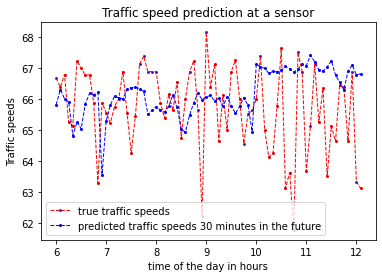

In [21]:
import matplotlib.pyplot as plt

#REALY GOOD LINK FOR PLOTTING https://www.geeksforgeeks.org/graph-plotting-in-python-set-1/

#[15:90,5,2], [115:200,5,205]
# x axis values
x_1 = data['y_test'][16:90,5,0,1]*24#data['y_test'][15:200,5,0,1]*24
# corresponding y axis values
y_1 = scaler.inverse_transform(data['y_test'][16:90,5,205,0])

print(predictions.size)
x_2 = data['y_test'][16:90,5,0,1]*24
# corresponding y axis values
y_2 = scaler.inverse_transform(predictions[16:90])
  
# plotting the points 
plt.plot(x_1, y_1, label = "true traffic speeds", color='red', linestyle='dashed', linewidth = 1,
         marker='o', markerfacecolor='blue', markersize=2)

# plotting the points 
plt.plot(x_2, y_2, label = "predicted traffic speeds 30 minutes in the future", color='blue', linestyle='dashed', linewidth = 1,
         marker='o', markerfacecolor='blue', markersize=2)

  
# naming the x axis
plt.xlabel('time of the day in hours')
# naming the y axis
plt.ylabel('Traffic speeds')

# show a legend on the plot
plt.legend()

# giving a title to my graph
plt.title('Traffic speed prediction at a sensor')
  
# function to show the plot
plt.show()

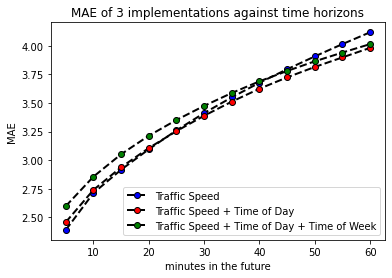

In [22]:
import matplotlib.pyplot as plt

#REALY GOOD LINK FOR PLOTTING https://www.geeksforgeeks.org/graph-plotting-in-python-set-1/

# x axis values
x_1 = [5,10,15,20,25,30,35,40,45,50,55,60]
# corresponding y axis values
y_1 = [2.3898053, 2.7128036, 2.9167628, 3.095644, 3.2612026, 3.4126213, 3.550242, 3.67795, 3.7960541, 3.908467, 4.0162163, 4.1197243]

# x axis values
x_2 = [5,10,15,20,25,30,35,40,45,50,55,60]
# corresponding y axis values
y_2 = [2.4580932, 2.7401118, 2.9383361, 3.1065338, 3.2545528, 3.3890703, 3.5126808, 3.625508, 3.7249336, 3.815912, 3.8996491, 3.9832518]

x_3 = [5,10,15,20,25,30,35,40,45,50,55,60]
# corresponding y axis values
y_3 = [2.598255, 2.8561628, 3.0521493, 3.2139802, 3.3520217, 3.475436, 3.588266, 3.690245, 3.7807834, 3.8653638, 3.9422936, 4.0159106]
  
# plotting the points 
plt.plot(x_1, y_1, label = "Traffic Speed", color='black', linestyle='dashed', linewidth = 2,
         marker='o', markerfacecolor='blue', markersize=6)

plt.plot(x_2, y_2, label="Traffic Speed + Time of Day", color='black', linestyle='dashed', linewidth = 2,
         marker='o', markerfacecolor='red', markersize=6)

plt.plot(x_3, y_3, label="Traffic Speed + Time of Day + Time of Week", color='black', linestyle='dashed', linewidth = 2,
         marker='o', markerfacecolor='green', markersize=6)
  
# naming the x axis
plt.xlabel('minutes in the future')
# naming the y axis
plt.ylabel('MAE')

# show a legend on the plot
plt.legend()

# giving a title to my graph
plt.title('MAE of 3 implementations against time horizons')
  
# function to show the plot
plt.show()

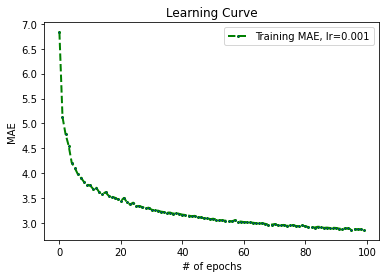

In [23]:
# x axis values
x = range(100)
# corresponding y axis values
y = [6.8311, 5.1302, 4.7845, 4.5549, 4.2129, 4.1074, 3.9803, 3.9096, 3.8256, 3.7717, 3.7559, 3.6821, 3.7092, 3.6138, 3.5847, 3.6184, 3.5497, 3.5325, 3.5103, 3.4770, 3.4470, 3.5055, 3.4139,
       3.3757, 3.4095, 3.3432, 3.3425, 3.3212, 3.2950, 3.3095, 3.2681, 3.2558, 3.2509, 3.2299, 3.2211, 3.2110, 3.2108, 3.1892, 3.2021, 3.1844, 3.1694, 3.1616, 3.1500, 3.1376, 3.1449, 3.1187, 3.1124, 3.0967, 3.1087, 3.0769,
       3.0876, 3.0711, 3.0587, 3.0530, 3.0478, 3.0445, 3.0337, 3.0560, 3.0300, 3.0306, 3.0197, 3.0163, 3.0134, 3.0066, 2.9968, 2.9919, 2.9965, 2.9836, 2.9662, 2.9684, 2.9799, 2.9568, 2.9574, 2.9623, 2.9424, 2.9547,
       2.9606, 2.9406, 2.9376, 2.9537, 2.9328, 2.9208, 2.9199, 2.9098, 2.9255, 2.9245, 2.9031, 2.9089, 2.9011, 2.9062, 2.9014, 2.8884, 2.8819, 2.8930, 2.8933, 2.8673, 2.8737, 2.8751, 2.8748, 2.8623]
  
# plotting the points 
plt.plot(x, y, label = "Training MAE, lr=0.001", color='green', linestyle='dashed', linewidth = 2,
         marker='o', markerfacecolor='blue', markersize=2)
  
# naming the x axis
plt.xlabel('# of epochs')
# naming the y axis
plt.ylabel('MAE')

# show a legend on the plot
plt.legend()

# giving a title to my graph
plt.title('Learning Curve')
  
# function to show the plot
plt.show()